<a href="https://colab.research.google.com/github/vvillbiii/business-data-analytics-and-intelligence-colab-notebooks/blob/main/Google_Causal_Impact_Will.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries and Dates

In [ ]:
#install libraries
!pip install yfinance
!pip install tfcausalimpact

In [ ]:
# import libraries 
import yfinance as yf
from causalimpact import CausalImpact
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# dates
training_start = "2020-09-01"
training_end = "2020-10-19"
treatment_start = "2020-10-20"
treatment_end = "2020-10-23"
end_stock = "2020-10-24"

# loading financial data 

In [ ]:
#Bitcoin
y = ['BTC-USD']
y = yf.download(tickers= y, 
                start= training_start, 
                end=end_stock, 
                interval='1d')
y = y['Adj Close'].rename("y")
y[:5]

In [ ]:
#Loading more stock data
stocks = ['META', 'DIS', 'NVS', "CRSP", 'GOOG']
X = yf.download(tickers=stocks, 
                start=training_start, 
                end=end_stock, 
                interval='1d')


[*********************100%***********************]  5 of 5 completed


## Preparing data

In [ ]:
#getting adjusted close
X = X.iloc[:, :len(stocks)]
X.head()

Adj Close                                     \
                                CRSP         DIS       GOOG        META   
Date                                                                      
2020-09-01 00:00:00-04:00  93.419998  133.550003  83.035500  295.440002   
2020-09-02 00:00:00-04:00  93.930000  135.389999  86.414001  302.500000   
2020-09-03 00:00:00-04:00  85.690002  133.240005  82.092003  291.119995   
2020-09-04 00:00:00-04:00  82.019997  131.990005  79.552002  282.730011   
2020-09-08 00:00:00-04:00  81.459999  134.199997  76.619499  271.160004   

                                      
                                 NVS  
Date                                  
2020-09-01 00:00:00-04:00  80.162483  
2020-09-02 00:00:00-04:00  81.998825  
2020-09-03 00:00:00-04:00  80.374718  
2020-09-04 00:00:00-04:00  79.987144  
2020-09-08 00:00:00-04:00  80.586967

In [ ]:
#removing level
X.columns = X.columns.droplevel()
X.head(1)

,AMZ,DIS,GOOG,META,NVS
Date,,,,,
2020-09-01 00:00:00-04:00,NaN,133.550003,83.0355,295.440002,80.162476


In [ ]:
#Time zones
# had to search through discord chat to find the right answer
X.index = X.index.tz_localize(None)
y.index = y.index.tz_localize(None)

In [ ]:
#Combine everything
df = pd.concat([y, X], axis = 1).dropna()
df.head()

,y,"(Adj Close, CRSP)","(Adj Close, DIS)","(Adj Close, GOOG)","(Adj Close, META)","(Adj Close, NVS)"
Date,,,,,,
2020-09-01,11970.478516,93.419998,133.550003,83.035500,295.440002,80.162483
2020-09-02,11414.034180,93.930000,135.389999,86.414001,302.500000,81.998825
2020-09-03,10245.296875,85.690002,133.240005,82.092003,291.119995,80.374718
2020-09-04,10511.813477,82.019997,131.990005,79.552002,282.730011,79.987144
2020-09-08,10131.516602,81.459999,134.199997,76.619499,271.160004,80.586967


# DATA Analysis section

In [ ]:
#prepare a dataframe with only training data
df_training = df[df.index <= training_end]
df_training.tail(1)

,y,"(Adj Close, CRSP)","(Adj Close, DIS)","(Adj Close, GOOG)","(Adj Close, META)","(Adj Close, NVS)"
Date,,,,,,
2020-10-19,11742.037109,107.720001,124.230003,76.730499,261.399994,79.165871


In [ ]:
#stationarity 
from statsmodels.tsa.stattools import adfuller
test = adfuller(x = df_training.y)[1]

#how to read if else
if test < 0.05:
  print("The time series is stationary")
else:
  print("The time series is not stationary")

The time series is not stationary


In [ ]:
#Differencing: subtract or divide
differencing = df_training.pct_change().dropna()
differencing.head(2)

,y,"(Adj Close, CRSP)","(Adj Close, DIS)","(Adj Close, GOOG)","(Adj Close, META)","(Adj Close, NVS)"
Date,,,,,,
2020-09-02,-0.046485,0.005459,0.013778,0.040687,0.023897,0.022908
2020-09-03,-0.102395,-0.087725,-0.015880,-0.050015,-0.037620,-0.019806


In [ ]:
test = adfuller(x = differencing.y)[1]

#how to read if else
if test < 0.05:
  print("The time series is stationary")
else:
  print("The time series is not stationary")

The time series is stationary


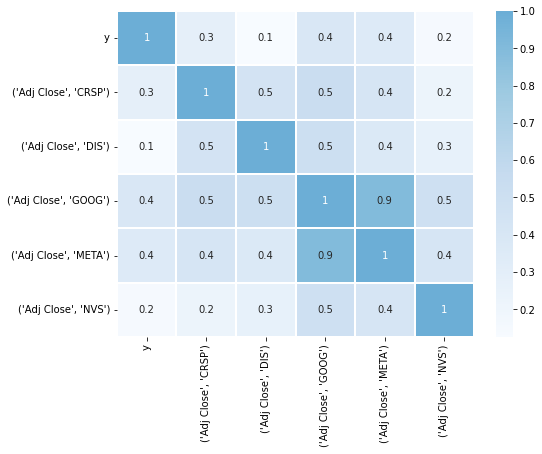

In [ ]:
#correlation martix
plt.figure(figsize = (8,6))
sns.heatmap(differencing.corr(),
            annot =True,
            fmt='.1g',
            cmap ="Blues",
            center = True,
            linewidth = 1)

# Causal Impact 

In [ ]:
#pre and post period 
pre_period = [training_start, training_end]
post_period = [treatment_start, treatment_end]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))
Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


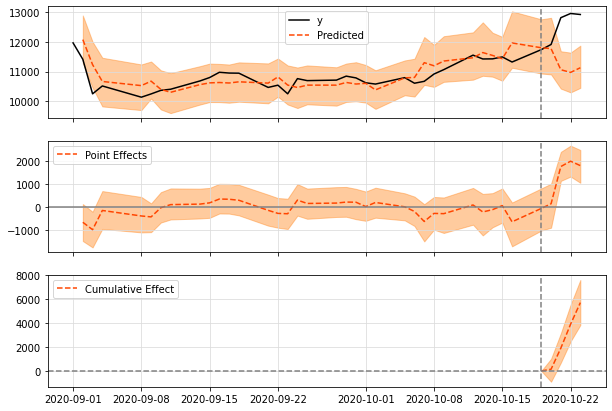

In [ ]:
#google causal impact
impact = CausalImpact(data = df,
                      pre_period = pre_period,
                      post_period = post_period)
impact.plot()

In [ ]:
#summary
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    12659.36           50637.45
Prediction (s.d.)         11234.16 (233.89)  44936.64 (935.55)
95% CI                    [10785.88, 11702.7][43143.51, 46810.81]

Absolute effect (s.d.)    1425.2 (233.89)    5700.81 (935.55)
95% CI                    [956.66, 1873.49]  [3826.64, 7493.94]

Relative effect (s.d.)    12.69% (2.08%)     12.69% (2.08%)
95% CI                    [8.52%, 16.68%]    [8.52%, 16.68%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [ ]:
#summary report 
print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 12659.36. By contrast, in the absence of an
intervention, we would have expected an average response of 11234.16.
The 95% interval of this counterfactual prediction is [10785.88, 11702.7].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 1425.2 with a 95% interval of
[956.66, 1873.49]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 50637.45.
By contrast, had the intervention not taken place, we would have expected
a sum of 44936.64. The 95% interval of this prediction is [43143.51, 46810.81].


The above results are given in terms of absolute numbers. In relative
ter